In [70]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import umap
#from hdbscan import HDBSCAN
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq, GeneralizedDoubleKMeans, generalized_double_kmeans, estimate_pq_with_umap_hdbscan
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_spectral_clustering_elbows 
from src.plot_util import  plot_heatmap_with_cluster_boundaries,plot_bicluster_grid, plot_biclustering_elbow, plot_biclustering_elbows, plot_bicluster_heatmaps_grid
from src.utils import preprocess_sales_matrix, generate_store_item_clusters, normalize_store_item_matrix
from src.cluster_util import compute_spectral_clustering_cv_scores, compute_biclustering_scores


In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-07-08'

In [73]:
# load
dtype_dict = {
    "store": "uint16",
    "item": "uint32",
    "store_item": "string",        # allow NaNs as <NA>
    "unit_sales": "float32",
    "id": "Int64",                 # nullable integer
    "onpromotion": "boolean",      # if you want True/False with nulls
}
#df = pd.read_csv("../output/data/20250707_train_top_51_store_9000_item_sales.csv", dtype=dtype_dict)
#df = pd.read_csv("../output/data/20250707_500_train_top_51_store_9000_item_sales.csv", dtype=dtype_dict)
df = pd.read_csv("../output/data/20250707_train_top_51_store_100_item.csv", 
                 dtype=dtype_dict,
                 parse_dates=["date"],
                 keep_default_na=True,
                 na_values=[""])
# Convert nullable Int64 or boolean to float64 with NaN
cols = ['date', 'store_item', 'store', 'item'] + [c for c in df.columns 
                                   if c not in ('date', 'store_item', 'store', 'item')]
df = df[cols]
df["id"] = df["id"].astype("float64")   # <NA> → np.nan
df["id"] = df["id"].astype(object).where(df["id"].notna(), np.nan)
df["store_item"] = df["store_item"].astype(object).where(df["store_item"].notna(), np.nan)
df["onpromotion"] = df["onpromotion"].astype(object).where(df["onpromotion"].notna(), np.nan)
df["date"] = pd.to_datetime(df["date"])

df.head()

,date,store_item,store,item,unit_sales,id,onpromotion
0,2013-01-01,NaN,44,1503844,NaN,NaN,NaN
1,2013-01-02,NaN,44,1503844,NaN,NaN,NaN
2,2013-01-03,NaN,44,1503844,NaN,NaN,NaN
3,2013-01-04,NaN,44,1503844,NaN,NaN,NaN
4,2013-01-05,NaN,44,1503844,NaN,NaN,NaN


In [74]:
df.shape

(8588400, 7)

In [75]:
print(df["unit_sales"].notna().sum())
df[df["unit_sales"].notna()]


5928413


,date,store_item,store,item,unit_sales,id,onpromotion
365,2014-01-02,44_1503844,44,1503844,966.148987,16377457.0,NaN
366,2014-01-03,44_1503844,44,1503844,663.405029,16442863.0,NaN
367,2014-01-04,44_1503844,44,1503844,1075.000000,16511061.0,NaN
368,2014-01-05,44_1503844,44,1503844,892.607971,16578789.0,NaN
369,2014-01-06,44_1503844,44,1503844,261.553986,16642520.0,NaN
...,...,...,...,...,...,...,...
8588395,2017-08-11,30_1114566,30,1114566,2.000000,125029635.0,False
8588396,2017-08-12,30_1114566,30,1114566,51.000000,125134885.0,False
8588397,2017-08-13,30_1114566,30,1114566,5.000000,125240337.0,False
8588398,2017-08-14,30_1114566,30,1114566,14.000000,125345167.0,False


In [79]:
df = df[df["unit_sales"].notna()]
print(df.shape)
print(df['store'].nunique())
print(df['item'].nunique())


(5928413, 7)
51
100


In [81]:
print(df["item"].nunique())
print(df["store"].nunique())

100
51


In [82]:
# df["dayofweek"] = df["date"].dt.dayofweek
# df["month"] = df["date"].dt.month
# df["weekofyear"] = df["date"].dt.isocalendar().week
# df

In [83]:
df_weekly = normalize_store_item_matrix(df, freq="W")
    

In [84]:
df_weekly.shape

(51, 100)

In [85]:
df_weekly

item,115611,116017,159156,215352,219150,220435,222879,257847,261052,265254,...,1473482,1502392,1503844,1503847,1584575,1642399,1686656,1693648,1695835,1751174
store,,,,,,,,,,,,,,,,,,,,,
1,-0.586375,-0.798743,0.609361,-0.352634,-0.158049,-0.251283,-0.879106,-0.586375,-0.523397,-0.251283,...,0.690373,1.239994,2.662335,1.221460,0.506522,1.797993,0.400558,0.457547,1.340337,0.901534
2,0.242067,-0.334319,0.946864,-0.482053,-0.649540,0.263882,-0.406012,-1.351460,-0.082620,-0.482053,...,0.535576,0.421305,2.557866,0.965518,0.814975,0.955653,0.425951,0.506010,0.472346,0.326540
3,-0.276172,-0.897228,-0.020800,-0.539391,-0.539391,0.050311,-1.170048,-0.026901,-0.356476,-0.088978,...,0.812688,0.993751,2.331072,1.103972,0.904343,0.448689,-0.443770,0.549442,1.154510,0.894216
4,-0.162627,-0.774357,1.081474,-0.308932,-0.308932,0.294142,-0.666276,-1.250091,0.086636,-0.095468,...,0.731980,0.603082,2.440964,1.032014,1.224807,0.627659,-0.095468,0.383064,0.876254,0.535493
5,-0.179815,-0.382275,0.911252,-0.382275,-0.689103,1.060632,0.413818,-2.000562,0.821173,-1.090189,...,0.493849,-0.447313,1.012346,-0.256201,0.528098,0.216214,-0.004436,0.836969,-0.973565,0.589570
6,-0.311001,-0.282313,1.001717,-0.642547,-0.433025,0.311805,-0.370487,-1.838390,0.202549,-0.148198,...,0.331775,-0.174074,2.266973,0.962449,0.927625,0.705125,1.696835,0.278273,0.488045,0.393074
7,-1.017479,-1.190282,0.556850,-0.827285,-0.260660,-0.087857,-0.827285,-1.401776,-0.472154,-0.128195,...,0.879187,1.289533,2.519525,1.119150,0.826839,1.164640,1.437556,0.596082,1.790020,1.178667
8,-0.627184,-0.929540,0.117145,-0.488896,-0.563467,-0.077246,-0.845414,-0.563467,-0.341379,-0.002142,...,0.844653,1.122467,2.696081,1.079478,0.813270,0.880616,-0.077246,0.486464,1.453735,1.099875
9,0.481397,0.357461,-2.601100,-0.234251,-0.182498,0.243471,0.302367,-1.417676,0.908190,-0.348242,...,-0.196752,-1.763059,-1.987893,-1.844021,0.458008,0.572613,-1.818899,0.179255,-0.007740,-1.194404


In [44]:
df_weekly.to_csv("../output/data/20250707_train_top_51_store_100_item_weekly.csv", index=False)

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


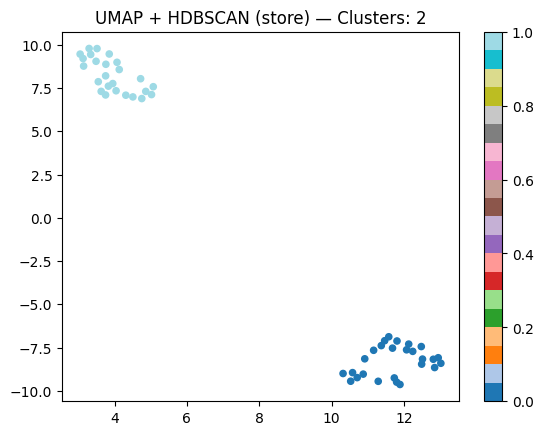

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


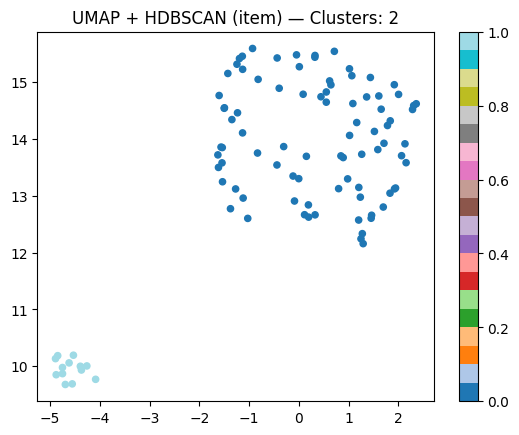

In [14]:
def plot_umap_hdbscan(X, title="UMAP + HDBSCAN", axis_label="row", n_neighbors=10, min_dist=0.1, min_cluster_size=15):
    embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42).fit_transform(X)
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size).fit(embedding)
    
    labels = clusterer.labels_
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=20)
    plt.title(f"{title} ({axis_label}) — Clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    plt.colorbar()
    plt.show()

plot_umap_hdbscan(df_weekly.values, title="UMAP + HDBSCAN", axis_label="store", n_neighbors=10, min_dist=0.1, min_cluster_size=15)
plot_umap_hdbscan(df_weekly.values.T, title="UMAP + HDBSCAN", axis_label="item", n_neighbors=15, min_dist=0.01, min_cluster_size=5)

In [86]:
cluster_result = compute_biclustering_scores(
    data=df_weekly.values,
    model_class=SpectralBiclustering,
    row_range=range(2, 5),
    col_range=range(2, 5),
    true_row_labels=None,
    model_kwargs=None,
    return_models=True,
)
cluster_result

2025-07-08 12:30:29,442 - INFO - Evaluating n_row=2, n_col=2
2025-07-08 12:30:29,784 - INFO - Evaluating n_row=2, n_col=3
2025-07-08 12:30:29,976 - INFO - Evaluating n_row=2, n_col=4
2025-07-08 12:30:30,157 - INFO - Evaluating n_row=3, n_col=2
2025-07-08 12:30:30,322 - INFO - Evaluating n_row=3, n_col=3
2025-07-08 12:30:30,496 - INFO - Evaluating n_row=3, n_col=4
2025-07-08 12:30:30,687 - INFO - Evaluating n_row=4, n_col=2
2025-07-08 12:30:30,852 - INFO - Evaluating n_row=4, n_col=3
2025-07-08 12:30:31,153 - INFO - Evaluating n_row=4, n_col=4


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI,row_labels,col_labels,model
0,2,2,10.350624,0.111467,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(2, 2), random..."
1,2,3,58.158237,0.486451,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(2, 3), random..."
2,2,4,58.158237,0.486451,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, ...","SpectralBiclustering(n_clusters=(2, 4), random..."
3,3,2,33.006999,0.210395,NaN,"[2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 2), random..."
4,3,3,62.769398,0.327955,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 3), random..."
5,3,4,62.769398,0.327955,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 4), random..."
6,4,2,39.480521,0.164168,NaN,"[2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 2), random..."
7,4,3,65.314081,0.145081,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 3), random..."
8,4,4,65.314081,0.145081,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, ...","[2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 4), random..."


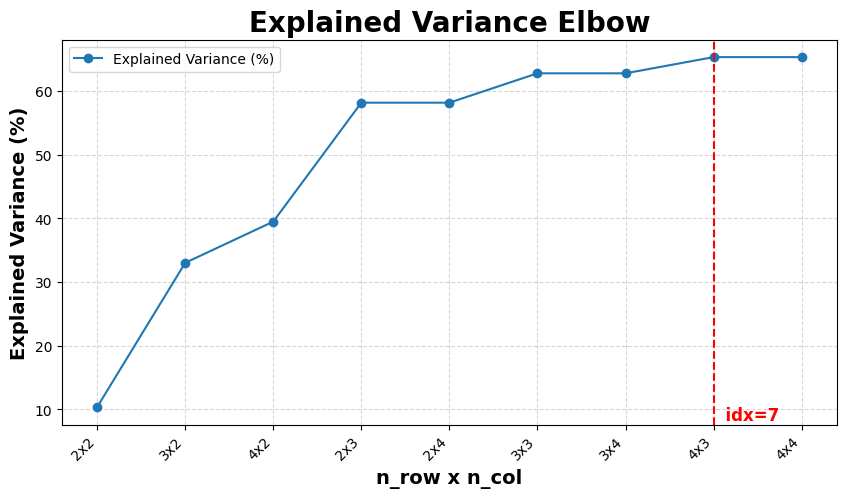

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI,row_labels,col_labels,model,label
0,2,2,10.350624,0.111467,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(2, 2), random...",2x2
1,3,2,33.006999,0.210395,NaN,"[2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 2), random...",3x2
2,4,2,39.480521,0.164168,NaN,"[2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 2), random...",4x2
3,2,3,58.158237,0.486451,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(2, 3), random...",2x3
4,2,4,58.158237,0.486451,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, ...","SpectralBiclustering(n_clusters=(2, 4), random...",2x4
5,3,3,62.769398,0.327955,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 3), random...",3x3
6,3,4,62.769398,0.327955,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(3, 4), random...",3x4
7,4,3,65.314081,0.145081,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 3), random...",4x3
8,4,4,65.314081,0.145081,NaN,"[2, 2, 2, 2, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0, 0, ...","[2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 0, ...","SpectralBiclustering(n_clusters=(4, 4), random...",4x4


In [61]:
plot_biclustering_elbows(
    cluster_result,
    metric="Explained Variance (%)",
    vline_index=7,
    title="Explained Variance Elbow",
    fn="../output/figures/20250708_biclustering_elbows_explained_variance_51_stores_100_items.tiff",
)

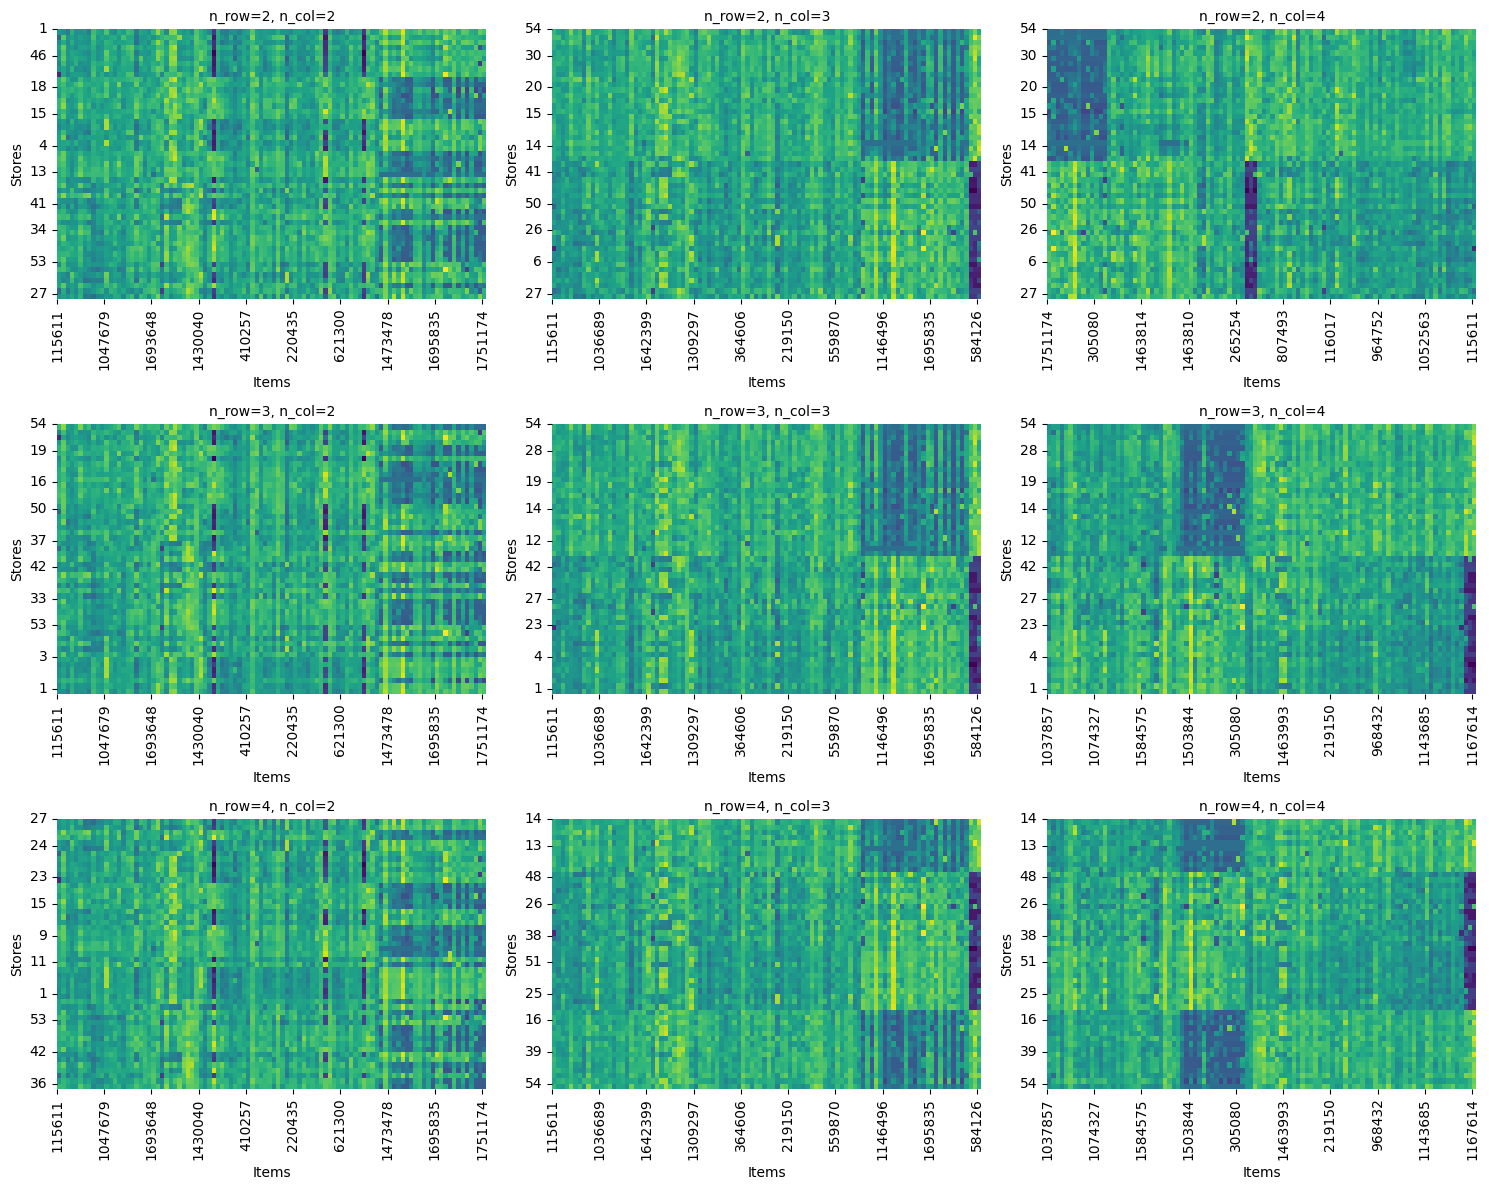

In [62]:
plot_bicluster_heatmaps_grid(df_weekly, 
                             cluster_result, 
                             heatmaps_per_row=3,
                             figsize_per_heatmap=(5, 4),
                             show_tick_labels=True,
                             fn="../output/figures/20250708_biclustering_heatmaps_51_stores_100_items.tiff")


In [63]:
cluster_result.to_csv("../output/data/20250708_spectral_cluster_df.csv", index=False)

In [87]:
# Select the best clustering result
best_idx = cluster_result["Explained Variance (%)"].idxmax()
best_row = cluster_result.loc[best_idx]
best_model = best_row["model"]

store_labels = best_model.row_labels_
item_labels = best_model.column_labels_
n_row_clusters = best_row["n_row"]
n_col_clusters = best_row["n_col"]

# Map cluster labels to actual store and item IDs
store_ids = df_weekly.index.tolist()
item_ids = df_weekly.columns.tolist()

store_cluster_map = dict(zip(store_ids, store_labels))
item_cluster_map = dict(zip(item_ids, item_labels))

# Define combined cluster ID per (store, item)
def get_combined_cluster(store, item):
    s_cluster = store_cluster_map.get(store)
    i_cluster = item_cluster_map.get(item)
    if s_cluster is None or i_cluster is None:
        return None
    return f"{s_cluster}_{i_cluster}"  # or use: return s_cluster * n_col_clusters + i_cluster

# Apply to original DataFrame
df["store_cluster"] = df["store"].map(store_cluster_map)
df["item_cluster"] = df["item"].map(item_cluster_map)
df["cluster"] = df["store_cluster"].astype(int).astype(str) + "_" + df["item_cluster"].astype(int).astype(str)

# # Optional: Drop any unmatched entries
# df_raw = df_raw.dropna(subset=["cluster"])


In [88]:
df.head()

,date,store_item,store,item,unit_sales,id,onpromotion,store_cluster,item_cluster,cluster
365,2014-01-02,44_1503844,44,1503844,966.148987,16377457.0,NaN,2,1,2_1
366,2014-01-03,44_1503844,44,1503844,663.405029,16442863.0,NaN,2,1,2_1
367,2014-01-04,44_1503844,44,1503844,1075.000000,16511061.0,NaN,2,1,2_1
368,2014-01-05,44_1503844,44,1503844,892.607971,16578789.0,NaN,2,1,2_1
369,2014-01-06,44_1503844,44,1503844,261.553986,16642520.0,NaN,2,1,2_1


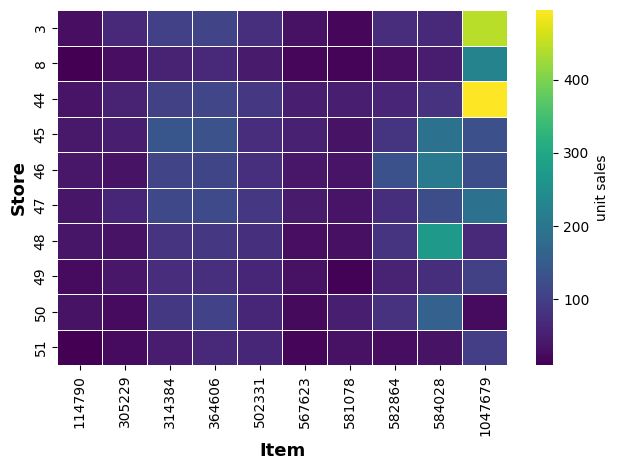

In [37]:
ax = sns.heatmap(
    store_item_matrix,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "unit sales"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()

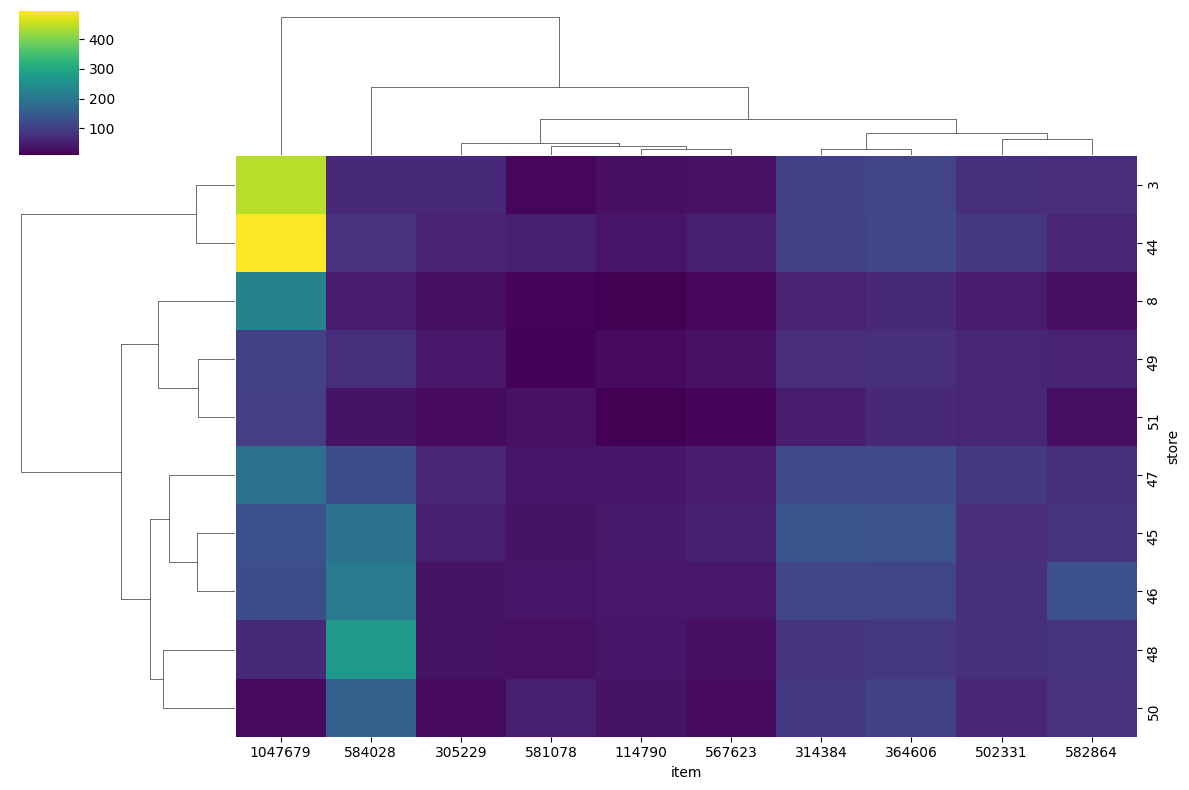

In [38]:
sns.clustermap(store_item_matrix, cmap='viridis', figsize=(12, 8))


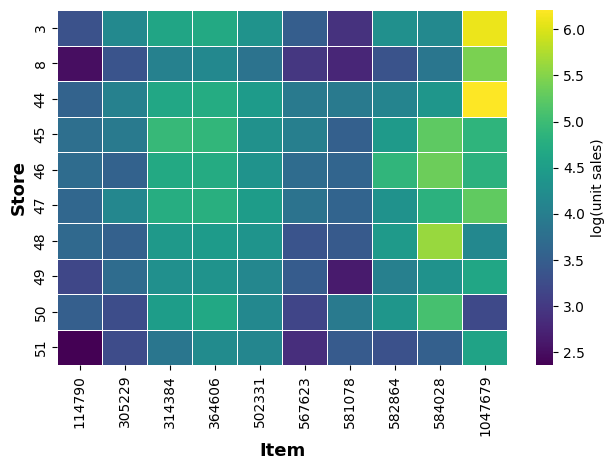

In [39]:
matrix_log = np.log1p(store_item_matrix)
ax = sns.heatmap(
    matrix_log,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(unit sales)"}
)

#ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Item", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",  fontsize=13, fontweight="bold")

plt.tight_layout()


<Axes: xlabel='item', ylabel='store'>

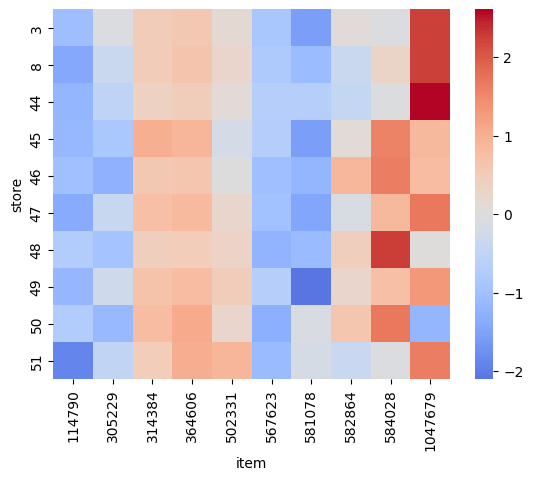

In [40]:
from scipy.stats import zscore

# Normalize each store’s sales profile across items
matrix_norm = matrix_log.apply(zscore, axis=1)  # axis=1 → row-wise
sns.heatmap(matrix_norm, cmap='coolwarm', center=0)

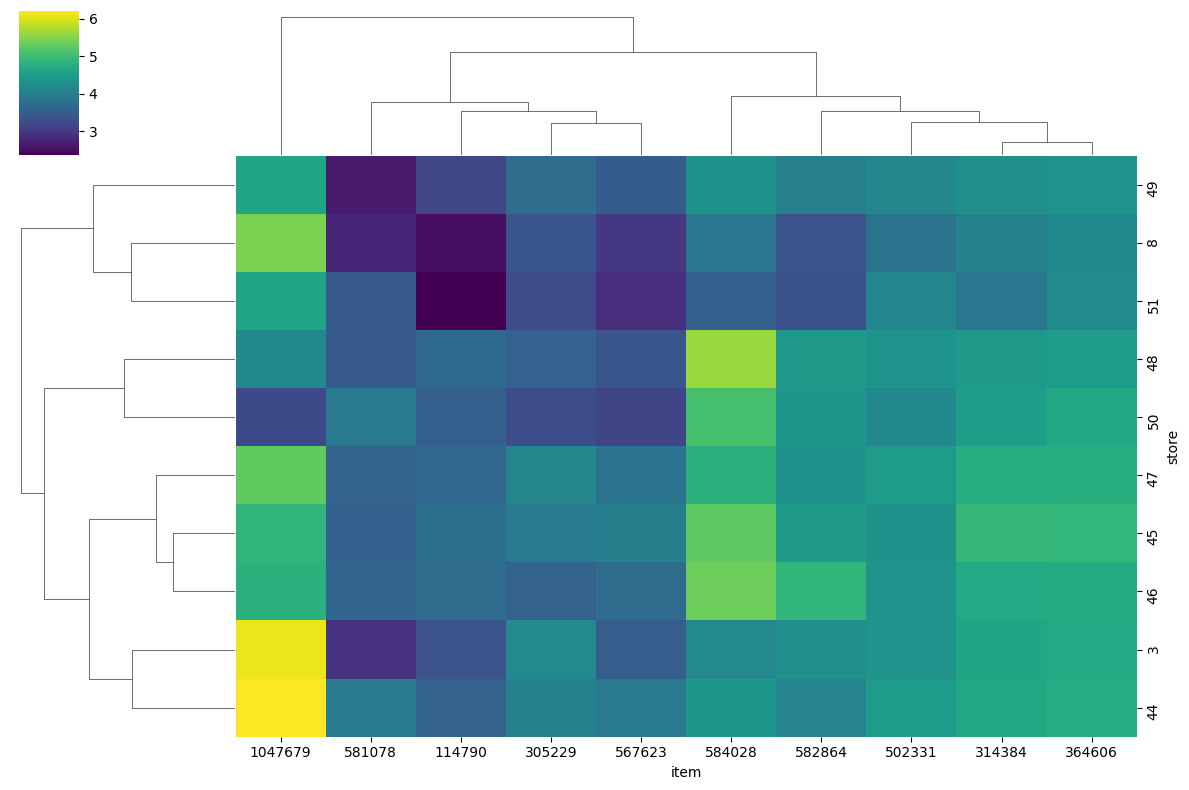

In [41]:
sns.clustermap(matrix_log, cmap='viridis', figsize=(12, 8))


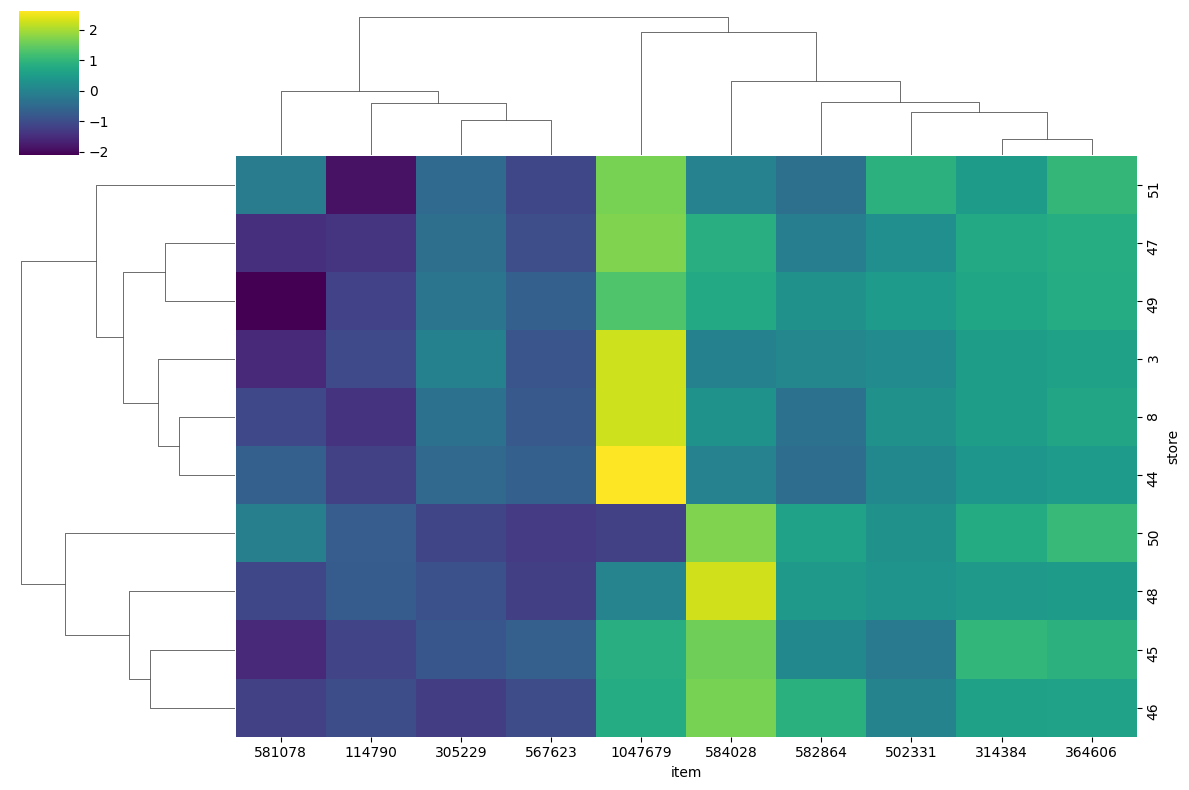

In [42]:
sns.clustermap(matrix_norm, cmap='viridis', figsize=(12, 8))


In [43]:
model = SpectralBiclustering(n_clusters=5, method='log', random_state=0)
model.fit(store_item_matrix)

SpectralBiclustering(method='log', n_clusters=5, random_state=0)

In [44]:
# Get reordered indices
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

# Reorder the matrix
matrix_ordered = store_item_matrix.iloc[row_order, col_order]

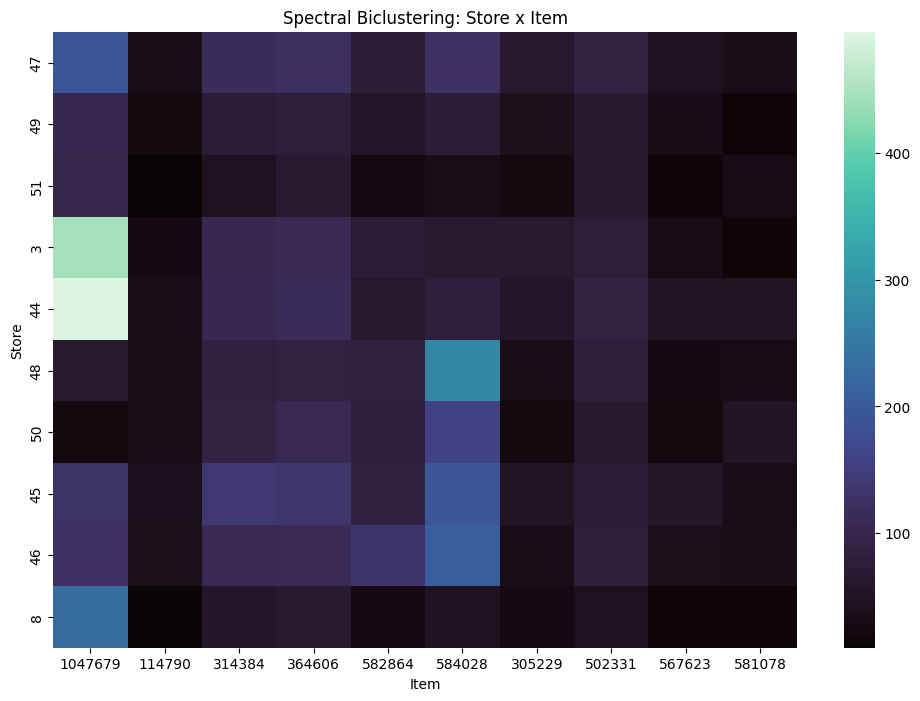

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako')
plt.title("Spectral Biclustering: Store x Item")
plt.xlabel("Item")
plt.ylabel("Store")
plt.show()


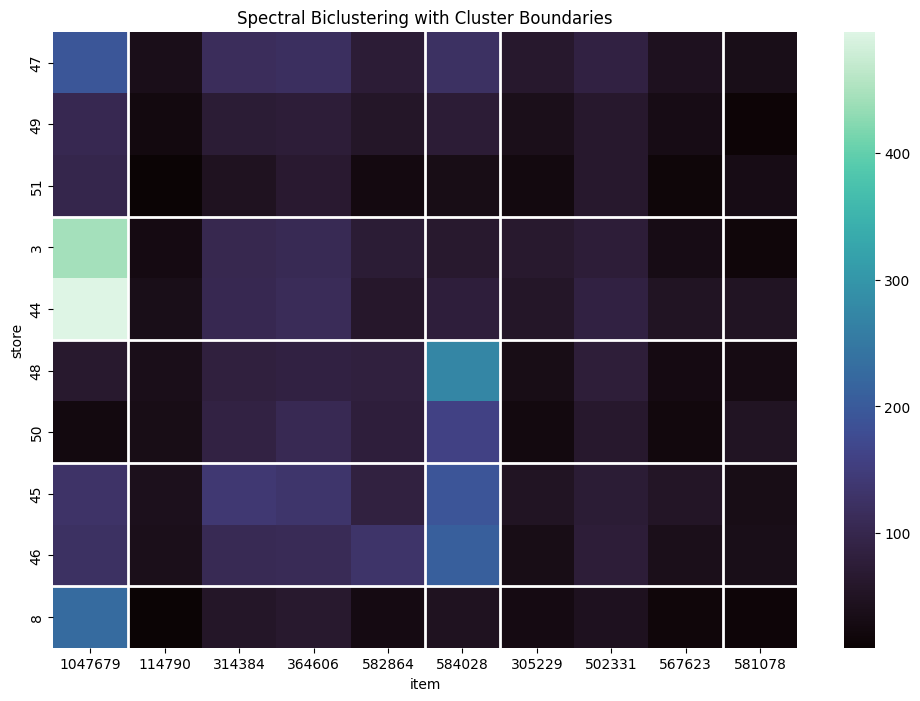

In [46]:
import numpy as np

# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()


In [47]:
model = SpectralBiclustering(n_clusters=7, method='log', random_state=0)
model.fit(matrix_norm)

SpectralBiclustering(method='log', n_clusters=7, random_state=0)

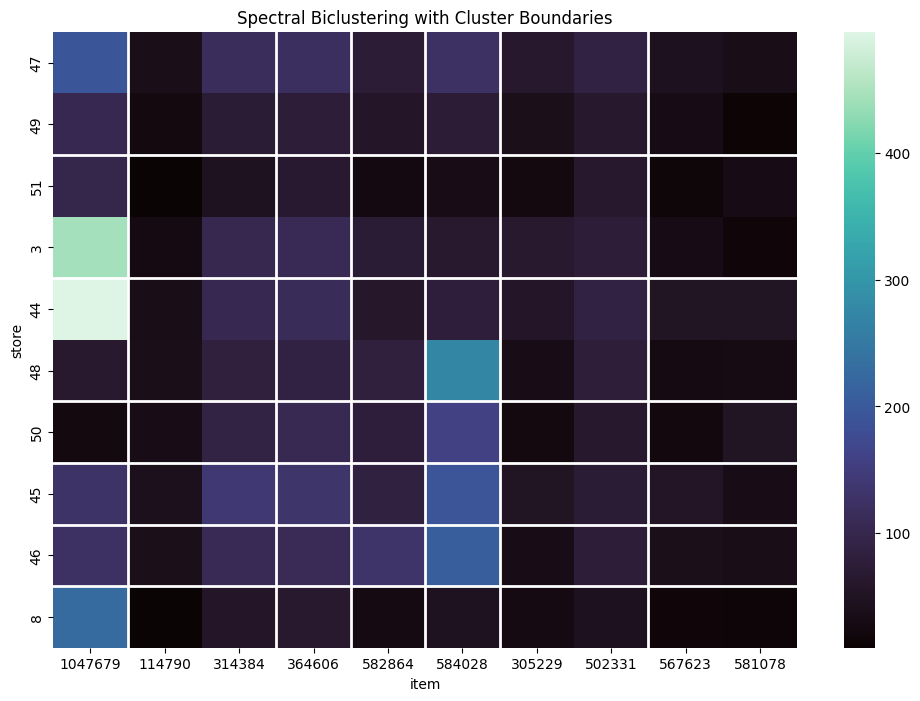

In [48]:
# Number of row/col clusters
n_row_clusters = len(set(model.row_labels_))
n_col_clusters = len(set(model.column_labels_))

# Row/Col boundaries
row_cuts = [np.where(np.diff(np.sort(model.row_labels_)) != 0)[0] + 1]
col_cuts = [np.where(np.diff(np.sort(model.column_labels_)) != 0)[0] + 1]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_ordered, cmap='mako', cbar=True)

for r in row_cuts[0]:
    plt.axhline(r, color='white', linewidth=2)
for c in col_cuts[0]:
    plt.axvline(c, color='white', linewidth=2)

plt.title("Spectral Biclustering with Cluster Boundaries")
plt.show()

In [58]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[5] * 5, random_state=0)
X_np = np.random.poisson(5, (10, 8))  # Placeholder in case store_item_matrix is unavailable here
model.fit(X_np)

ValueError: All column cluster blocks are empty or malformed.

In [62]:
X_debug = np.random.poisson(5, (10, 25))  # 10 stores, 25 items

U_dbg, V_list_dbg, C_blocks_dbg, loss_dbg = generalized_double_kmeans(
    X_debug,
    P=5,
    Q_list=[5] * 5,  # One Qp per row cluster
    max_iter=100,
    tol=1e-4,
    random_state=0
)

[(Vp.shape, Vp.ndim) for Vp in V_list_dbg]


[((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1),
 ((25,), 1)]

In [57]:
model = GeneralizedDoubleKMeans(n_row_clusters=5, n_col_clusters_list=[3] * 3, random_state=0)
model.fit(store_item_matrix.values)

IndexError: list index out of range

In [12]:

# Example: aggregate by dayofweek
store_clust_df = df.groupby(["store", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
store_clust_df

KeyError: 'dayofweek'

In [8]:
X, pivot_clean = preprocess_sales_matrix(store_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


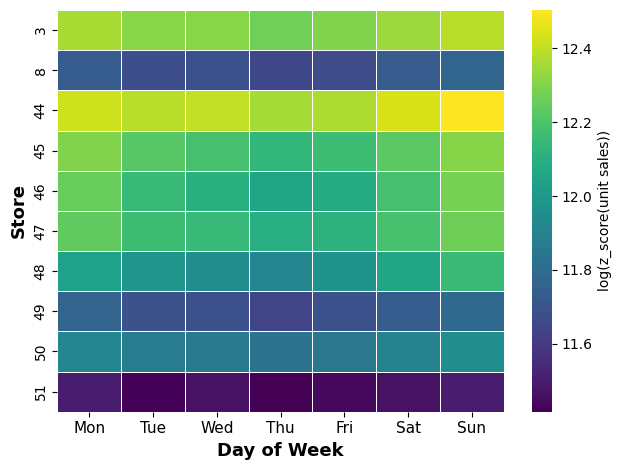

In [9]:

day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/2025-06-07_heatmap_store_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()



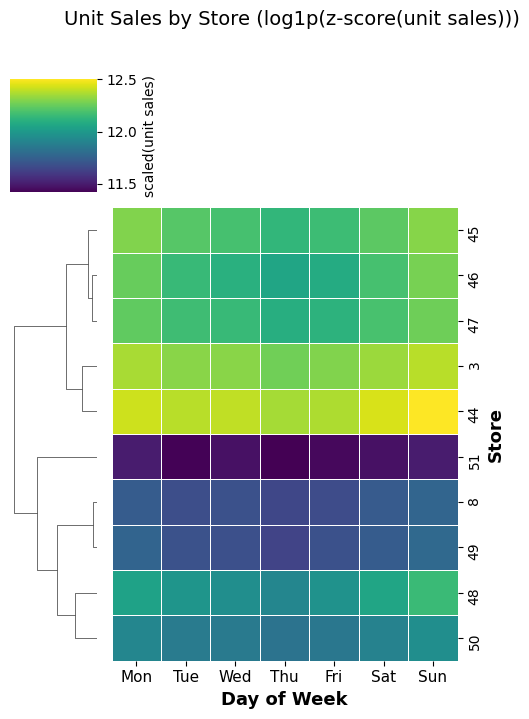

In [19]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Store",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Store (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)

# ---------------------------------------------------------------------
# FIRST let matplotlib tighten up everything *else* …
# ---------------------------------------------------------------------
#grid.figure.tight_layout(rect=[0, 0, 0.88, 1])     # leave room on the right

# ---------------------------------------------------------------------
# … THEN move / resize the colour‑bar
# ---------------------------------------------------------------------

# optional: put tick labels on the outside
#grid.cax.yaxis.set_label_position('right')
grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/2025-06-07_clustered_store_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [25]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,42.022753,0.541314,NaN
1,3,NaN,58.289140,0.225026,NaN
2,4,NaN,79.633059,0.458693,NaN
3,5,NaN,78.637807,0.458693,NaN
4,6,NaN,83.910748,0.445367,NaN


In [21]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,63.539831,0.541314,NaN
1,3,NaN,55.149080,0.392015,NaN
2,4,NaN,67.576050,0.392015,NaN
3,5,NaN,75.310768,0.177420,NaN
4,6,NaN,84.248961,0.458693,NaN


In [28]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,36.404406,0.541314,NaN
1,3,NaN,51.316306,0.541314,NaN
2,4,NaN,52.517374,0.177420,NaN
3,5,NaN,88.013466,0.445367,NaN
4,6,NaN,91.179629,0.445367,NaN


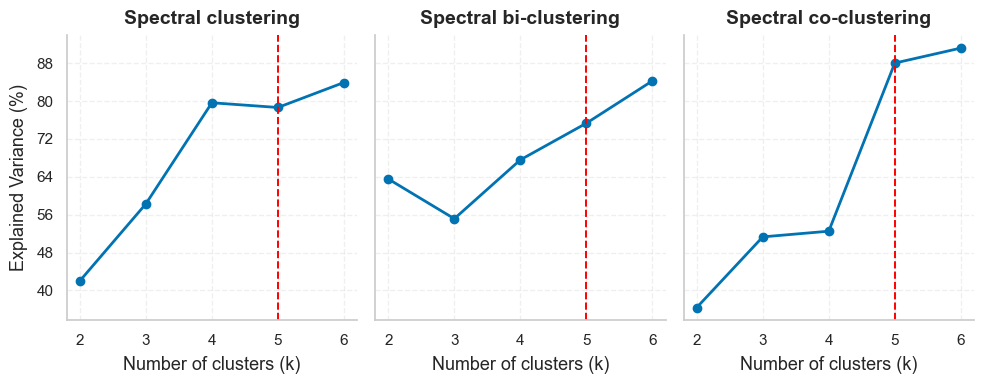

In [35]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_store_spectral_clustering_elbow.tiff")

In [36]:
store_clusters = generate_store_item_clusters(pivot_clean, n_clusters=5, model_class=SpectralClustering)
store_clusters

,store_item,clusterId
0,3,3
1,8,1
2,44,3
3,45,2
4,46,2
5,47,4
6,48,0
7,49,1
8,50,0
9,51,1


In [52]:
store_clusters.to_excel("../output/data/20250610_store_clusters.xlsx", index=False)


In [39]:
item_clust_df = df.groupby(["item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
item_clust_df

dayofweek,0,1,2,3,4,5,6
item,,,,,,,
114790,65934.00000,58541.000000,61027.000000,49694.000000,59724.00000,92168.000000,104334.000000
305229,100526.00000,87752.000000,96594.000000,77143.000000,94014.00000,113315.000000,126298.000000
314384,208535.00000,178413.000000,187639.000000,148368.000000,181779.00000,286893.000000,331265.000000
364606,233280.00000,206453.000000,218815.000000,177461.000000,195605.00000,278954.000000,326067.000000
502331,174052.00000,139167.000000,140516.000000,118401.000000,136309.00000,200200.000000,269012.000000
567623,80895.00000,65895.000000,66624.000000,52940.000000,61229.00000,100220.000000,135745.000000
581078,70016.00000,64095.000000,71520.000000,58879.000000,71888.00000,88769.000000,92420.000000
582864,148046.03125,131828.734375,130798.570312,123210.703125,262692.65625,173113.109375,183678.265625
584028,291425.68750,257868.406250,257720.062500,234997.234375,334694.56250,342394.843750,372661.968750


In [40]:
X, pivot_clean = preprocess_sales_matrix(item_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


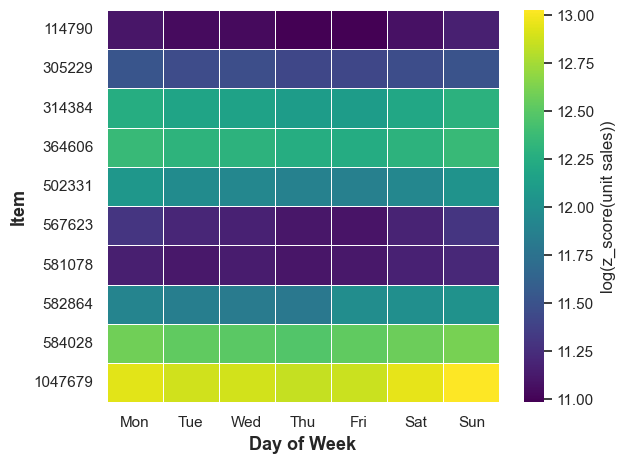

In [41]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Item",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/20250610_heatmap_item_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:34: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.tight_layout(rect=[0, 0, 0.88, 1])
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:40: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.savefig(fn, dpi=300    )
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


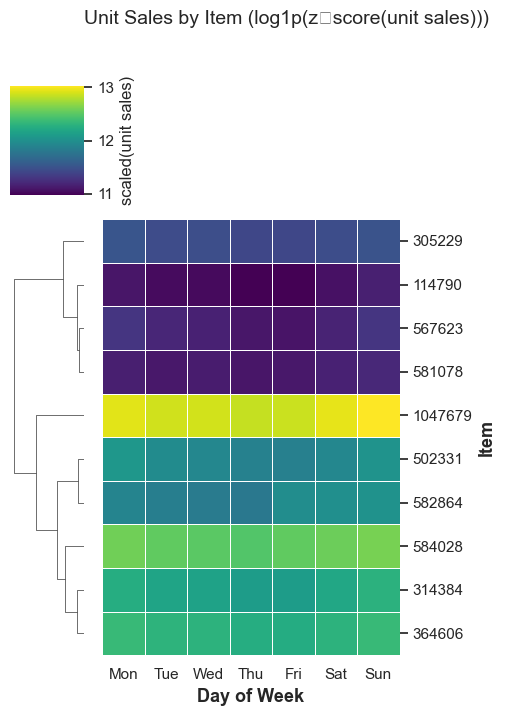

In [42]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Item",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Item (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)


grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/20250610_clustered_item_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [44]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning:

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,59.052952,0.502932,NaN
1,3,NaN,86.294428,0.297913,NaN
2,4,NaN,88.017222,0.482839,NaN
3,5,NaN,90.963996,0.514127,NaN
4,6,NaN,91.246928,0.514127,NaN


In [45]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 7),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,29.414937,0.502932,NaN
1,3,NaN,50.118215,0.585602,NaN
2,4,NaN,82.861211,0.585602,NaN
3,5,NaN,87.247744,0.236738,NaN
4,6,NaN,87.247744,0.236738,NaN


In [46]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,13.132559,0.248948,NaN
1,3,NaN,29.572957,0.502932,NaN
2,4,NaN,31.210978,0.502932,NaN
3,5,NaN,79.531610,0.514127,NaN
4,6,NaN,93.000911,0.585602,NaN


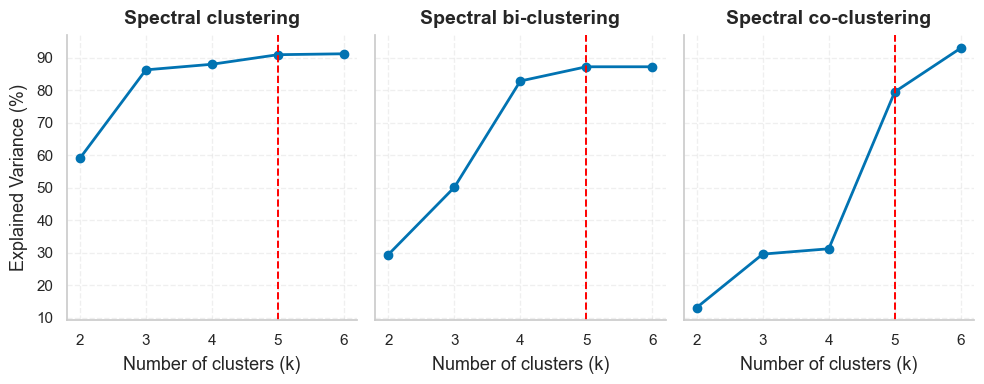

In [48]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_item_spectral_clustering_elbow.tiff")

In [49]:
item_clusters = generate_store_item_clusters(pivot_clean, n_clusters=4, model_class=SpectralClustering)
item_clusters

,store_item,clusterId
0,114790,1
1,305229,3
2,314384,2
3,364606,2
4,502331,3
5,567623,1
6,581078,1
7,582864,3
8,584028,2
9,1047679,0


In [50]:
item_clusters.to_excel("../output/data/20250610_item_clusters.xlsx", index=False)

In [ ]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(20, 30),   # Try 2 to 7 row clusters
    Q_range=range(20, 30),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


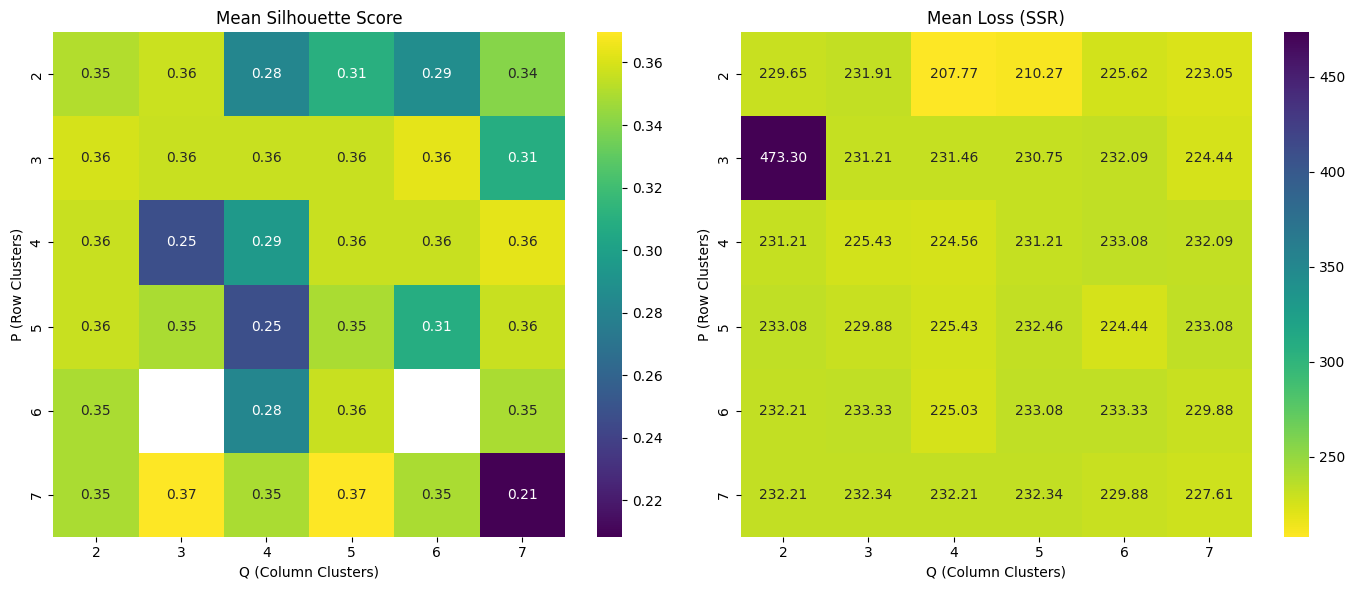

In [24]:
visualize_gdkm_cv_scores(results_df)

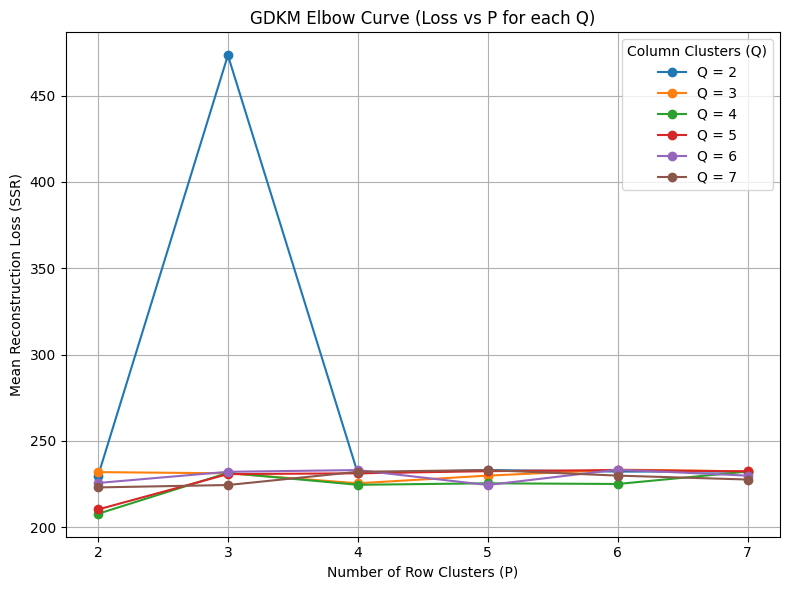

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
